In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 0)

import sys
sys.path.append('../')

import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm
tqdm.pandas()

from utils import generate_submit

In [3]:
train = pd.read_feather('../data/input/application_train.ftr')
test = pd.read_feather('../data/input/application_test.ftr')
bureau = pd.read_feather('../data/input/bureau.ftr')
pos = pd.read_feather('../data/input/pos_cash_balance.ftr')
previous = pd.read_feather('../data/input/previous_application.ftr')
card = pd.read_feather('../data/input/credit_card_balance.ftr')
submit = pd.read_feather('../data/input/sample_submission.ftr')

![](feats.png)

In [6]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


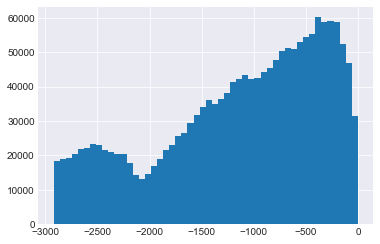

In [17]:
plt.hist(bureau.DAYS_CREDIT, bins=50)
plt.show()

In [70]:
# null counts
train['main_null_cnt'] = train.isnull().sum(axis=1)
test['main_null_cnt'] = test.isnull().sum(axis=1)
bureau['bureau_null_cnt'] = bureau.isnull().sum(axis=1)
pos['pos_null_cnt'] = pos.isnull().sum(axis=1)
previous['previous_null_cnt'] = previous.isnull().sum(axis=1)
card['card_null_cnt'] = card.isnull().sum(axis=1)

In [71]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [72]:
# https://www.kaggle.com/yekenot/catboostarter
pos['NAME_CONTRACT_STATUS'] = le.fit_transform(pos.NAME_CONTRACT_STATUS.astype(str))
nunique_status = pos[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status = nunique_status.NAME_CONTRACT_STATUS.reset_index().rename(columns={'NAME_CONTRACT_STATUS': 'pos_status_nunique'})
pos = pos.merge(nunique_status, on='SK_ID_CURR', how='left')
pos.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

In [73]:
card['NAME_CONTRACT_STATUS'] = le.fit_transform(card.NAME_CONTRACT_STATUS.astype(str))
nunique_status = card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status = nunique_status.NAME_CONTRACT_STATUS.reset_index().rename(columns={'NAME_CONTRACT_STATUS': 'card_status_nunique'})
card = card.merge(nunique_status, on='SK_ID_CURR', how='left')
card.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

In [74]:
bureau_cat = [f for f in bureau.columns if bureau[f].dtype == 'object']
for f in tqdm(bureau_cat):
    bureau[f] = le.fit_transform(bureau[f].astype(str))
    nunique = bureau[['SK_ID_CURR', f]].groupby('SK_ID_CURR').nunique()
    nunique = nunique[f].reset_index().rename(columns={f: 'nunique_'+f})
    bureau = bureau.merge(nunique, on='SK_ID_CURR', how='left')
    bureau.drop(f, axis=1, inplace=True)
bureau.drop('SK_ID_BUREAU', axis=1, inplace=True)

100%|██████████| 3/3 [00:16<00:00,  5.58s/it]


In [75]:
previous_cat = [f for f in previous.columns if previous[f].dtype == 'object']
for f in tqdm(previous_cat):
    previous[f] = le.fit_transform(previous[f].astype(str))
    nunique = previous[['SK_ID_CURR', f]].groupby('SK_ID_CURR').nunique()
    nunique = nunique[f].reset_index().rename(columns={f: 'nunique_'+f})
    previous = previous.merge(nunique, on='SK_ID_CURR', how='left')
    previous.drop(f, axis=1, inplace=True)
previous.drop('SK_ID_PREV', axis=1, inplace=True)

100%|██████████| 16/16 [02:49<00:00, 10.57s/it]


ValueError: labels ['SK_ID_previous'] not contained in axis

## Merge

In [92]:
pos_group = pos.groupby('SK_ID_CURR').mean()
pos_group['pos_count'] = pos.groupby('SK_ID_CURR').pos_null_cnt.count()
pos_group.reset_index(inplace=True)

In [96]:
card_group = card.groupby('SK_ID_CURR').mean()
card_group['card_count'] = card.groupby('SK_ID_CURR').card_null_cnt.count()
card_group.reset_index(inplace=True)

In [98]:
bureau_group = bureau.groupby('SK_ID_CURR').mean()
bureau_group['bureau_count'] = bureau.groupby('SK_ID_CURR').bureau_null_cnt.count()
bureau_group.reset_index(inplace=True)

In [99]:
previous_group = previous.groupby('SK_ID_CURR').mean()
previous_group['previous_count'] = previous.groupby('SK_ID_CURR').previous_null_cnt.count()
previous_group.reset_index(inplace=True)

In [101]:
data_train = train.merge(pos_group, on='SK_ID_CURR', how='left')\
    .merge(card_group, on='SK_ID_CURR', how='left')\
    .merge(bureau_group, on='SK_ID_CURR', how='left')\
    .merge(previous_group, on='SK_ID_CURR', how='left')
    
data_test = test.merge(pos_group, on='SK_ID_CURR', how='left')\
    .merge(card_group, on='SK_ID_CURR', how='left')\
    .merge(bureau_group, on='SK_ID_CURR', how='left')\
    .merge(previous_group, on='SK_ID_CURR', how='left')

In [104]:
y_train = data_train.TARGET
X_train = data_train.drop('TARGET', axis=1)
X_test = data_test

In [105]:
X_cat = [f for f in X_train.columns if X_train[f].dtype=='object']

In [107]:
for f in tqdm(X_cat):
    X_train[f] = le.fit_transform(X_train[f].astype(str))
    X_test[f] = le.transform(X_test[f].astype(str))

100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


In [110]:
X_train.fillna(-1, inplace=True)
X_test.fillna(-1, inplace=True)

In [113]:
print(X_train.shape)
print(X_test.shape)

(307511, 208)
(48744, 208)


In [122]:
X_train.to_feather('../data/working/X_train.ftr')
y_train.to_frame().to_feather('../data/working/y_train.ftr')
X_test.to_feather('../data/working/X_test.ftr')

## Modeling

In [127]:
import lightgbm as lgb
from sklearn.model_selection import KFold, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

In [129]:
cv = StratifiedKFold(5, shuffle=True, random_state=77)

In [138]:
lgb_params = {
#     'n_estimators'     : 4000,
    'learning_rate'    : 0.1,
    'num_leaves'       : 31,
    'colsample_bytree' : 0.8,
    'subsample'        : 0.9,
    'reg_alpha'        : 0.1,
    'reg_lambda'       : 0.1,
    'min_split_gain'   : 0.01,
    'min_child_weight' : 2,
    'random_state': 77
}

In [139]:
score = cross_validate(lgb.LGBMClassifier(**lgb_params), X_train, y_train, cv=cv.split(X_train, y_train), scoring='roc_auc', n_jobs=3, verbose=3)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ........................ , score=0.773020396730205, total= 1.5min
[CV]  ................................................................
[CV] ....................... , score=0.7702699625040351, total= 1.6min


[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min


[CV]  ................................................................
[CV] ....................... , score=0.7718301346420184, total= 1.6min
[CV] ....................... , score=0.7747873190049361, total= 1.2min
[CV] ....................... , score=0.7731261088439425, total= 1.2min


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  3.2min finished


In [166]:
valid_score = score['test_score'].mean()
print(valid_score)

0.7726067843450274


In [142]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=2, min_split_gain=0.01, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=77,
        reg_alpha=0.1, reg_lambda=0.1, silent=True, subsample=0.9,
        subsample_for_bin=200000, subsample_freq=1)

In [150]:
generate_submit(model.predict_proba(X_test)[:, 1], f'allfile_lgbm_baseline_{valid_score:.4f}')

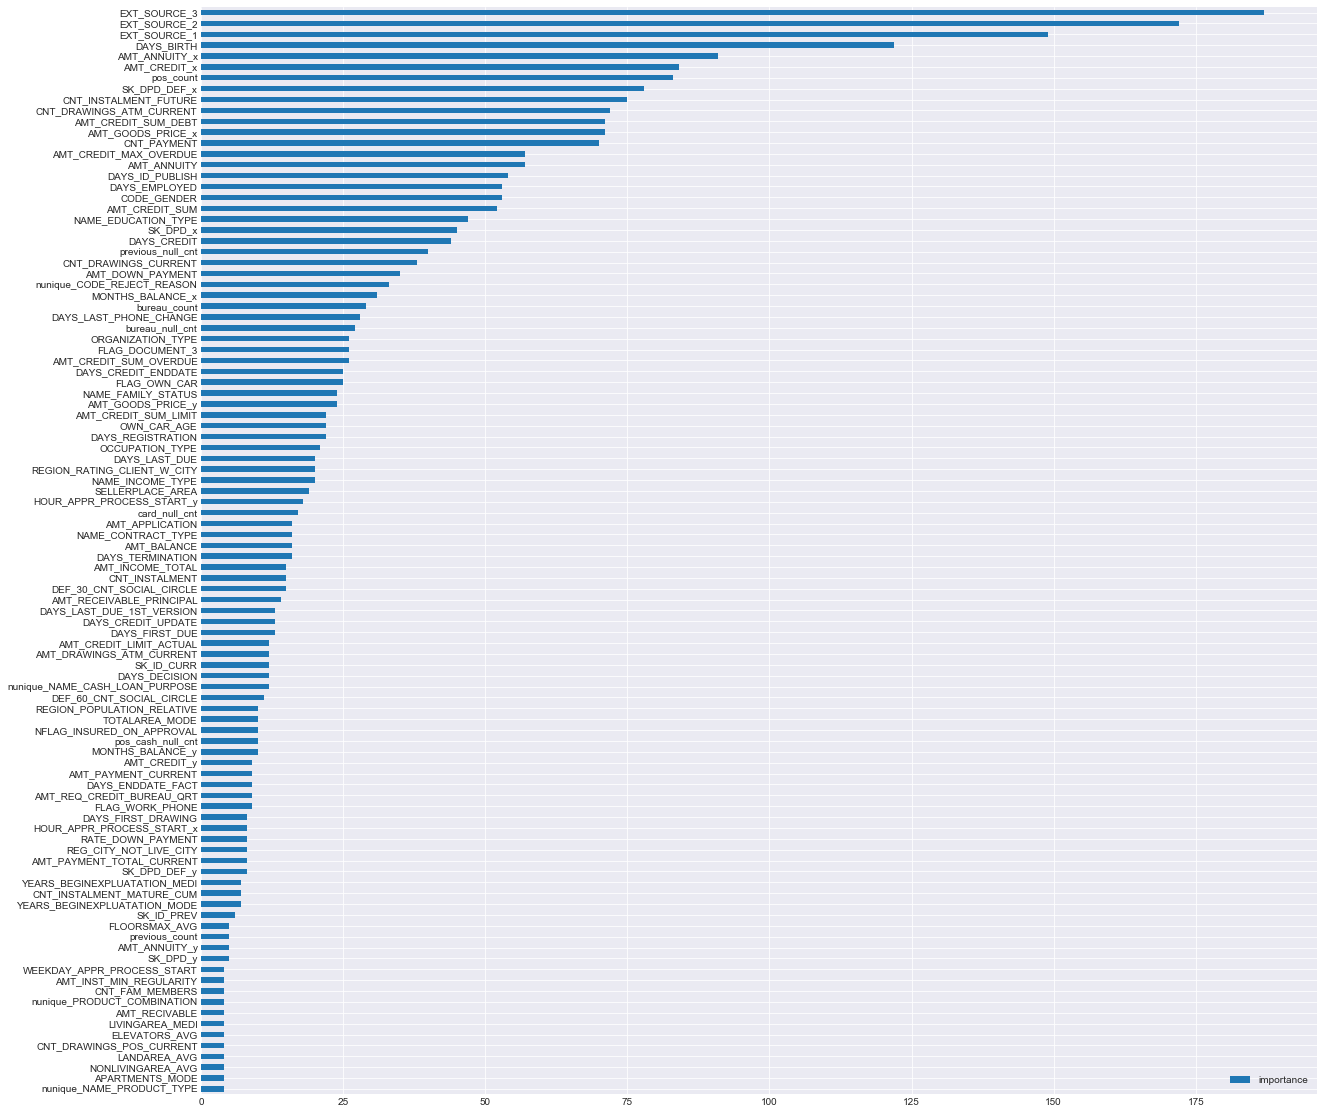

In [178]:
feat_df = pd.DataFrame({'importance': model.feature_importances_}, index=X_train.columns).sort_values('importance')
feat_df[-100:].plot.barh(figsize=(20, 20))
plt.savefig('feats.png')
plt.show()

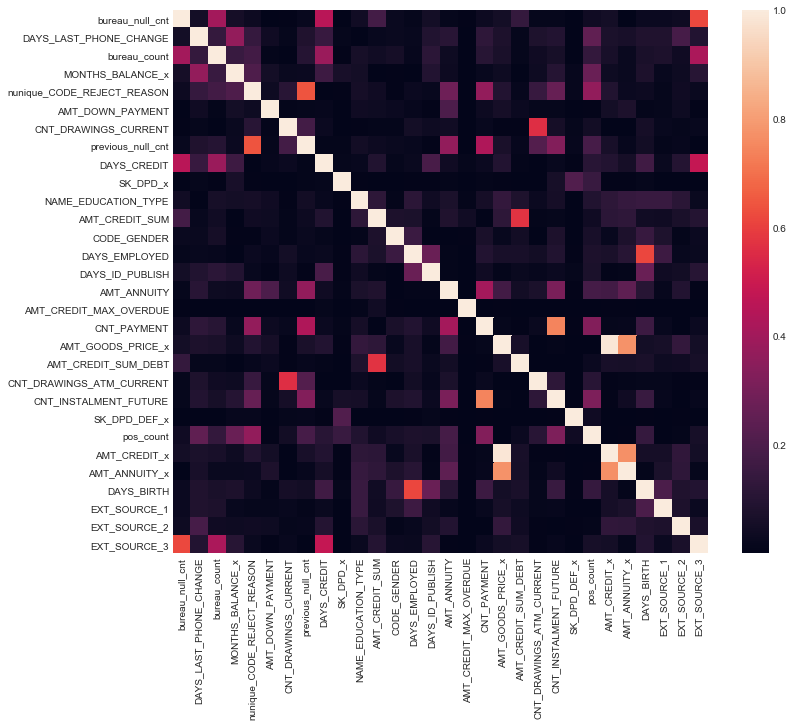

In [177]:
plt.figure(figsize=(12, 10))
sns.heatmap(abs(X_train[feat_df[-30:].index].corr()))
plt.show()